# Field Analysis


In [1]:
import numpy as np
from math import pi
from scipy.constants import c, e, epsilon_0
# h in eV
import scipy
h = scipy.constants.value('Planck constant in eV/Hz')
Z0 = pi * 119.916983 # V^2 / m

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from genesis import Genesis4

# Create field data

In [2]:
%%time
G = Genesis4('data/basic4/cu_hxr.in')
G.input['main'][1]['sample'] = 200
G.input['main'][6]['zstop'] = 40
G.input['main'].append({'type':'write', 'field':'end'})
G.nproc = None # Auto-select
G.run()

CPU times: user 31.4 ms, sys: 38.8 ms, total: 70.2 ms
Wall time: 1min 35s


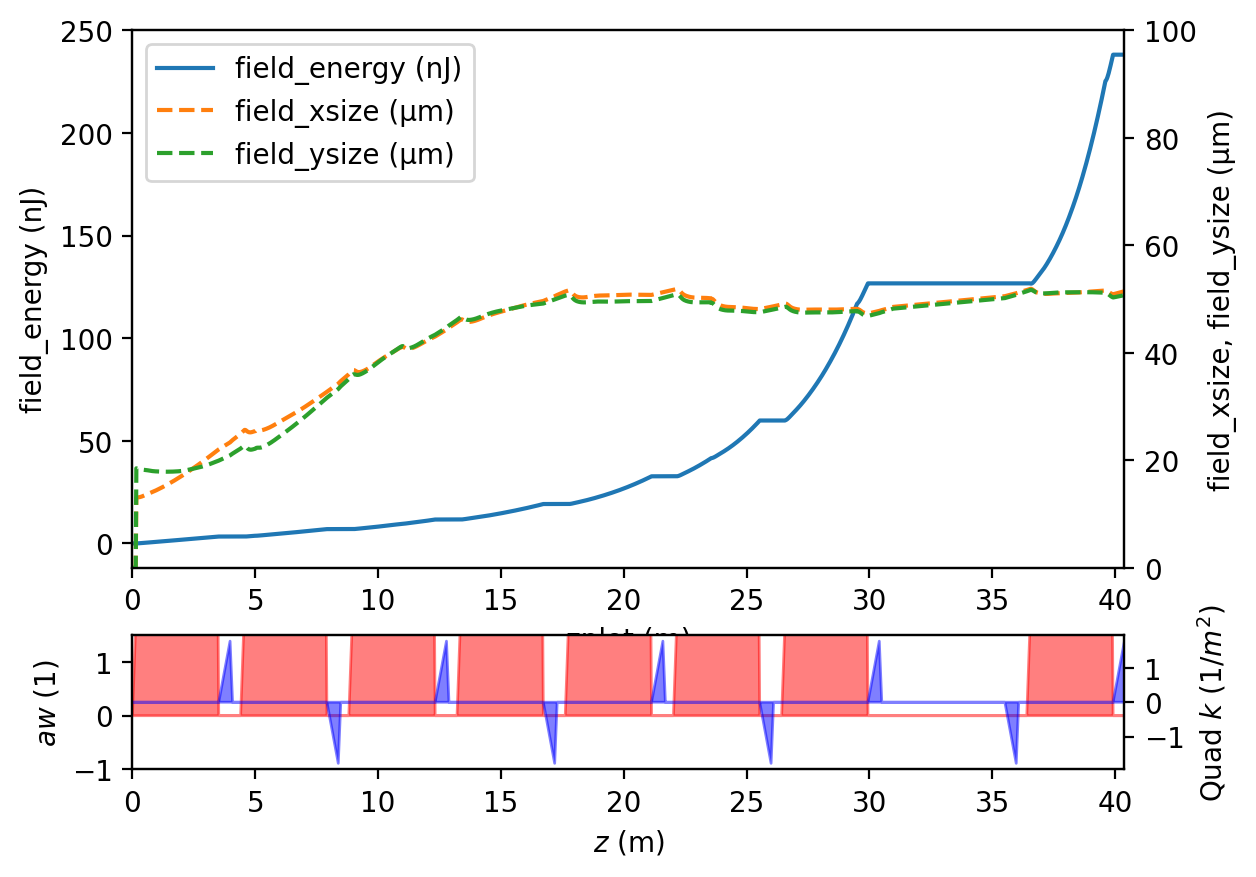

In [3]:
G.plot('field_energy', y2=['field_xsize', 'field_ysize'], ylim2 =[0, 100e-6])

In [4]:
G.verbose=True
G.load_fields()

Loaded field data: end


# 3D Field data

The full field data is stored as a 3D array of complex numbers `DFL` in units of `sqrt(W)`. The relation of this and the electric field `E` in V/m is
`E = DFL * sqrt(2*Z0) / Δ`, where `Z0 = π * 119.9169832 V^2/W` exactly and `Δ` is the grid spacing. 

In [5]:
DFL = G.field['end']['dfl'] # sqrt(W)

DFL.dtype, DFL.shape

(dtype('complex128'), (101, 101, 545))

In [6]:
param = G.field['end']['param']

param

{'gridpoints': 101,
 'gridsize': 2e-06,
 'refposition': 0.0,
 'wavelength': 1.3789244869952112e-10,
 'slicecount': 545,
 'slicespacing': 2.7578489739904225e-08}

Gather some convenient variables and arrays:

In [7]:
Ns = param['slicecount']
ds = param['slicespacing']
λ0 = param['wavelength']
f0 = c / λ0
dt = ds / c 
Δ = param['gridsize']

s = np.arange(0, Ns) * ds
t = -s/c

# Field power

The power array sums over the x and y components of the absolute square of the field data.

In [8]:
power0 = G.output['Field/power'][-1,:] # W

In [9]:
power1 = np.sum(np.sum(np.abs(DFL)**2, axis = 0), axis=0) # W

These are the same:

In [10]:
np.allclose(power0, power1)

True

Text(0, 0.5, 'power (GW)')

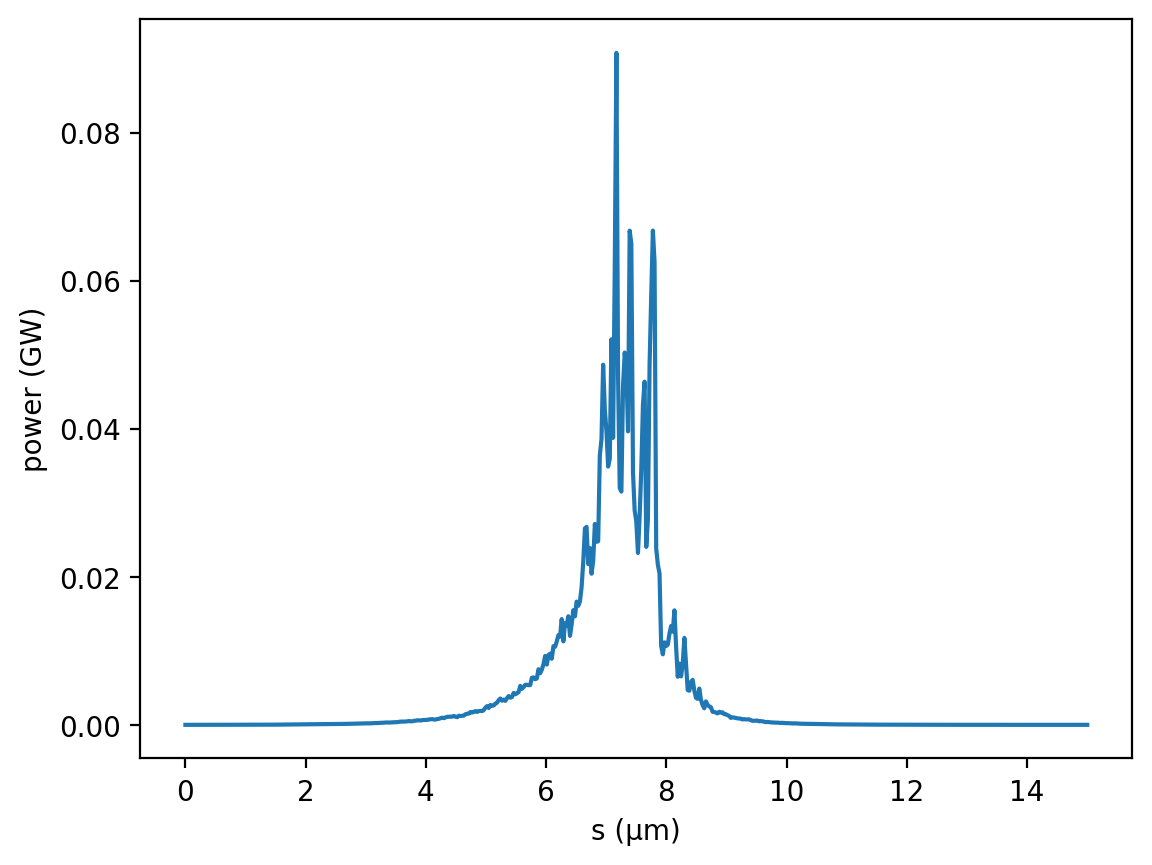

In [11]:
fig, ax = plt.subplots()
ax.plot(s * 1e6, power0 /1e9)
ax.set_xlabel('s (µm)')
ax.set_ylabel('power (GW)')

# Field energy

The total field energy is the integral:

In [12]:
energy1 = np.trapz(power1, dx = dt)

energy1 # J

2.3815389025212672e-07

In [13]:
np.sum(power1)*dt # J

2.381538935036637e-07

# On-axis field intensity and phase

In [14]:
intensity0 = G.output['Field/intensity-nearfield'][-1,:] # W/m^2
phase0 = G.output['Field/phase-nearfield'][-1,:] # radian

In [15]:
icenter = param['gridpoints']//2
field1= DFL[icenter, icenter, :]  # sqrt(W)
phase1 = np.angle(field1) # radian

intensity1 = np.abs(field1**2)/ Δ**2 # W/m^2

These are the same:

In [16]:
np.allclose(intensity0, intensity1)

True

In [17]:
np.allclose(phase0, phase1)

True

Text(0, 0.5, 'intensity (W/m$^2$)')

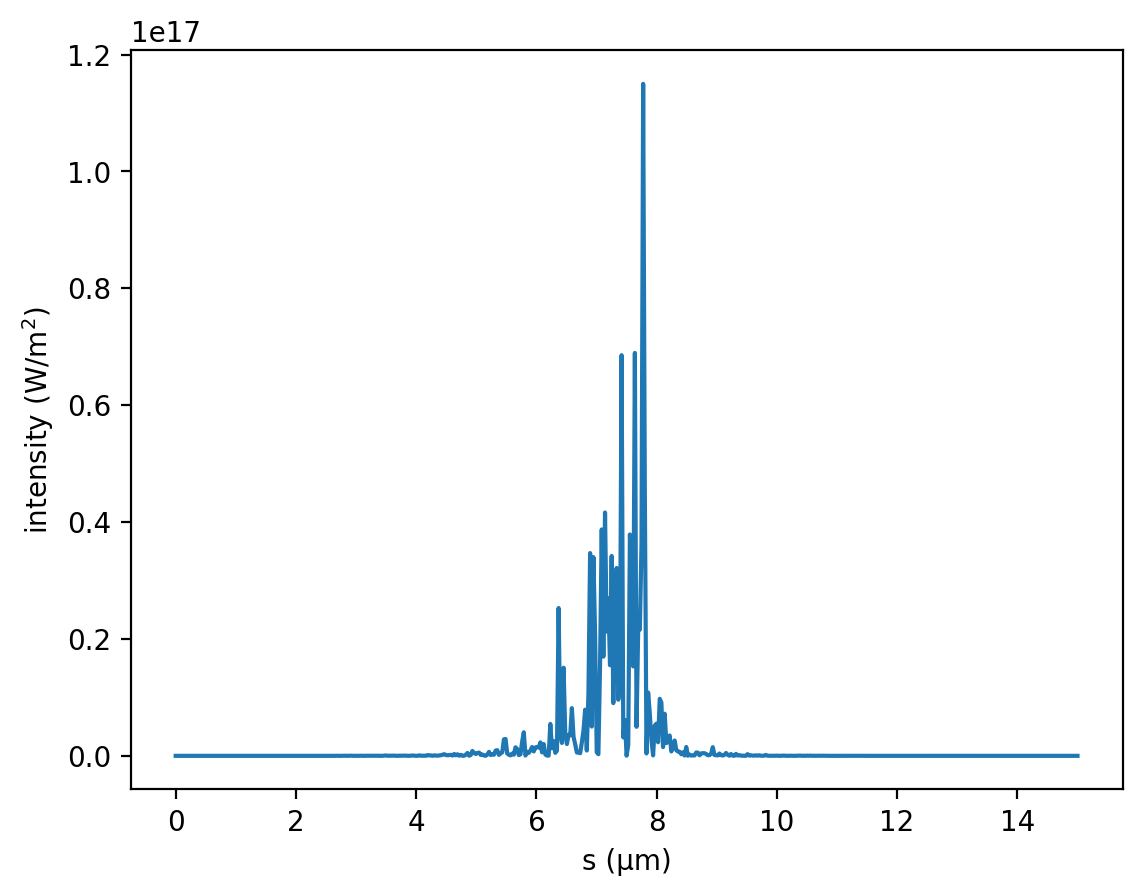

In [18]:
fig, ax = plt.subplots()
ax.plot(s * 1e6, intensity0)
ax.set_xlabel('s (µm)')
ax.set_ylabel(r'intensity (W/m$^2$)')

The same field can be reconstructed from these arrays

In [19]:
field0 = np.sqrt(intensity0) * np.exp(1j * phase0) * Δ # sqrt(W)

These are the same:

In [20]:
np.allclose(field0, field1)

True

# Spectral fluence

The spectrum calculation takes some care with the FFT and units.

In [21]:
def spectrum_from_field(field, dt=1):
    """
    Calculates the spectrum (fourier transformed field)
    from a complex field array with spacing dt.
    
    Parameters
    ----------
    field: nd.array of shape (n,) 
        Complex field
        
    dt: float
        Spacing of the field data in some units (e.g. 's')
    
    Returns
    -------
    freqs: nd.array of shape (n,)
        Frequencies in reciprocal space with inverse units (e.g. 'Hz = 1/s')
        
    spectrum: nd.array of shape (n,)
        The fourier transformed field
    
    """
    assert len(field.shape) == 1, 'Only 1D arrays are currently supported'
    spectrum = np.fft.fftshift(np.fft.fft(field))* dt
    
    ns = len(field)
    freqs = np.fft.fftshift(np.fft.fftfreq(ns, dt))

    return freqs, spectrum

In [22]:
freqs, spectrum = spectrum_from_field(field0, dt)

# Frequency spacing
#df = np.diff(freqs)[0] # Hz

df = 1/(dt*len(field0))

df

19945903846621.09

Check Plancherel theorem

In [23]:
np.sum(np.abs(field0)**2) * dt # J 

4.1023012138616886e-10

In [24]:
np.sum(np.abs(spectrum)**2) * df # J 

4.1023012138616886e-10

Text(0, 0.5, 'spectral fluence (J/m$^2$/eV)')

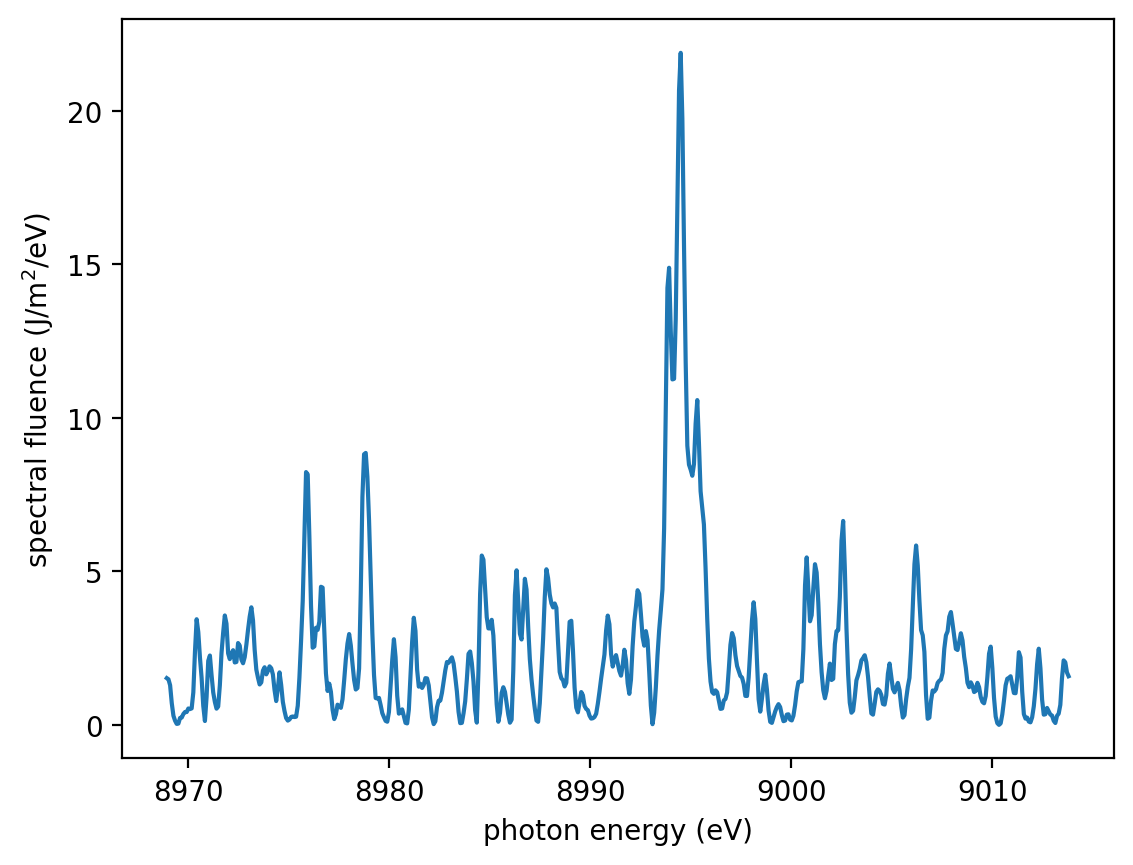

In [25]:
freqs, spectrum = spectrum_from_field(field0, dt)

fig, ax = plt.subplots()

photon_energies = h*(freqs + f0) # eV
spectral_fluence =  np.abs(spectrum**2) / Δ**2 / h # J/m^2/eV

ax.plot(photon_energies, spectral_fluence)
ax.set_xlabel('photon energy (eV)')
ax.set_ylabel(r'spectral fluence (J/m$^2$/eV)')

Text(0, 0.5, 'spectral intensity (photons/mm$^2$/eV)')

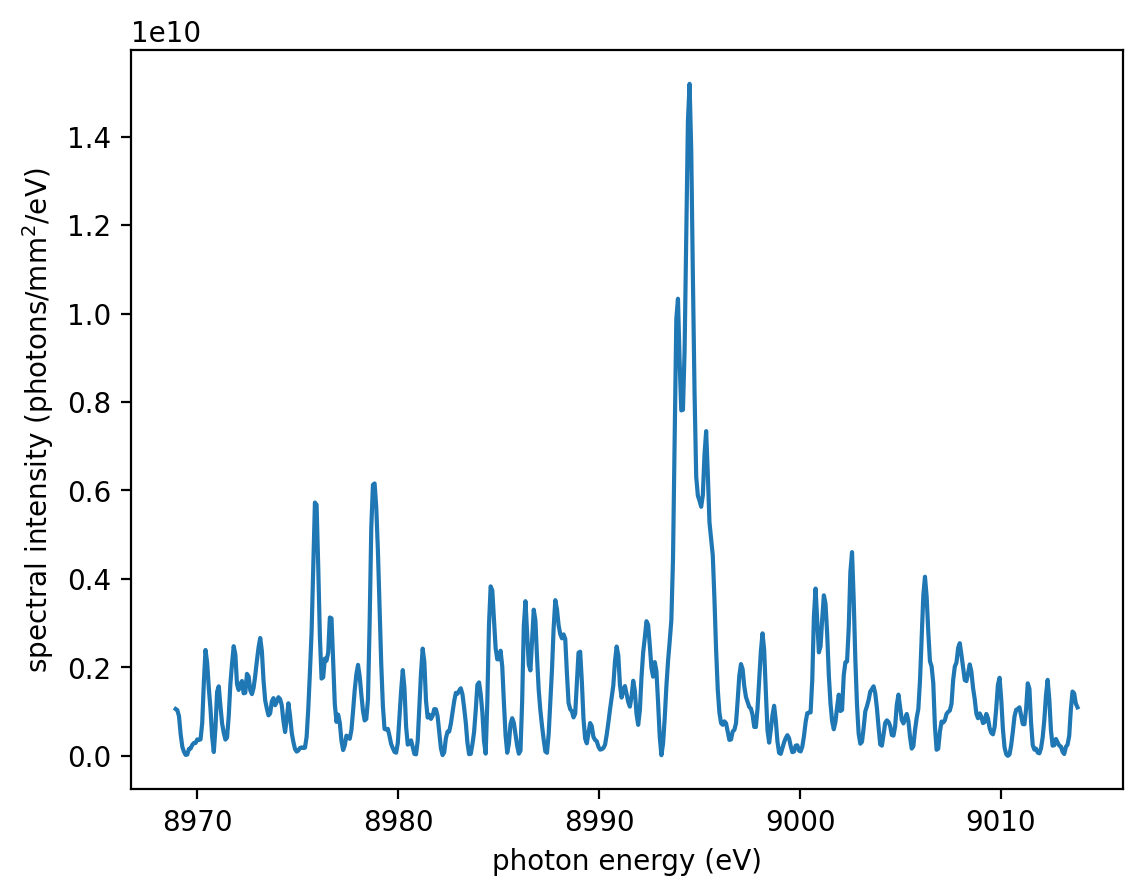

In [26]:
fig, ax = plt.subplots()
J_per_photon = (h*(freqs + f0)*e) # note h is in eV/Hz
ax.plot(photon_energies, spectral_fluence / J_per_photon  * 1e-6)
ax.set_xlabel('photon energy (eV)')
ax.set_ylabel(r'spectral intensity (photons/mm$^2$/eV)')

# 3D FFT

WORK IN PROGRESS

In [27]:
field3d = DFL * np.sqrt(2*Z0) / Δ # Electric field
#field3d = np.pad(field3d, 100, constant_values = 0) #Pad
nx, ny, nz = field3d.shape
dx, dy, dz = Δ, Δ, ds
nx, ny, nz, dx, dy, dz

# reciprocal spacings
dkx, dky, dkz = 1/(nx * dx), 1/(ny * dy), 1/(nz * dz) 

In [28]:
spectrum3d = np.fft.fftshift(np.fft.fftn(field3d)) * dx * dy * dz

In [29]:
# Check total energy integral
np.sum(np.abs(field3d)**2) * dx * dy * dz * epsilon_0 / 2

2.3815389297681002e-07

In [30]:
np.sum(np.abs(spectrum3d)**2) * dkx * dky * dkz * epsilon_0 / 2

2.3815389297681042e-07

In [31]:
kx = np.fft.fftshift(np.fft.fftfreq(nx, dx))
ky = np.fft.fftshift(np.fft.fftfreq(ny, dy))
kz = np.fft.fftshift(np.fft.fftfreq(nz, dz))

In [32]:
Kx, Ky, Kz = np.meshgrid(kx, ky, kz, indexing = 'ij')
kz0 = 2*pi / λ0
Kz  = Kz + kz0

K = np.sqrt(Kx**2 + Ky**2 + Kz**2)
k = K.flatten()
dEk = np.abs(spectrum3d.flatten())**2 *dkx * dky * dkz * epsilon_0 / 2

In [33]:
np.sum(dEk) 

2.3815389297680965e-07

Text(0, 0.5, 'spectral energy (µJ/eV)')

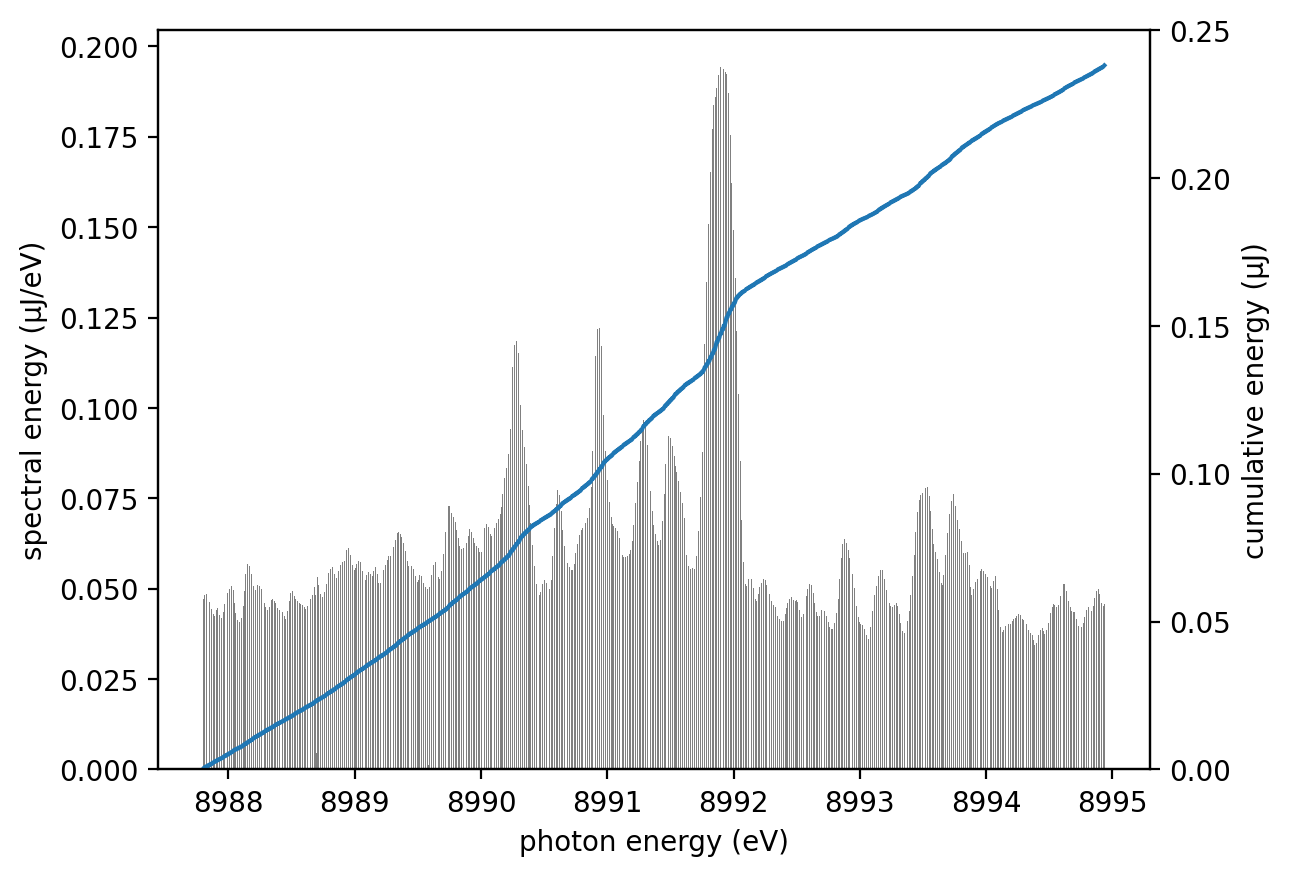

In [34]:
x = k * c * h / (2*pi) # eV
w = dEk
bins = 1000

hist, bin_edges = np.histogram(x, bins=bins, weights=w)
hist_x = bin_edges[:-1] + np.diff(bin_edges) / 2
hist_width =  np.diff(bin_edges)

hist_y = hist/hist_width
#hist_y, hist_f, hist_prefix = nice_array(hist/hist_width)

fig, ax = plt.subplots()
ax.bar(hist_x, hist_y*1e6, hist_width, color='gray')

ax2 = ax.twinx()
ax2.plot(hist_x, np.cumsum(hist) * 1e6)
ax2.set_ylabel('cumulative energy (µJ)')
ax2.set_ylim(0, None)

ax.set_xlabel('photon energy (eV)')
ax.set_ylabel('spectral energy (µJ/eV)')

# Field data formats

Genesis4 writes a custom field format. LUME-Genesis provides a reader for this, as well as a conversion tool to write in the [openPMD-wavefront standard](https://github.com/openPMD/openPMD-standard/blob/upcoming-2.0.0/EXT_Wavefront.md).

## Read Field h5

In [35]:
from genesis.version4 import readers
import h5py

In [36]:
FILE = G.output['field_files'][0]
FILE

'/var/folders/zh/21kc88xd58d9s5q2j5cxqjpc0000gn/T/tmpbknjrxst/end.fld.h5'

In [37]:
h5py.is_hdf5(FILE)

True

In [38]:
with h5py.File(FILE, 'r') as h5:
    DFL, PARAM = readers.load_genesis4_fields(h5)

In [39]:
DFL.shape, DFL.dtype, PARAM

((101, 101, 545),
 dtype('complex128'),
 {'gridpoints': 101,
  'gridsize': 2e-06,
  'refposition': 0.0,
  'wavelength': 1.3789244869952112e-10,
  'slicecount': 545,
  'slicespacing': 2.7578489739904225e-08})

## Write Wavefront in openPMD-wavefront

In [40]:
from genesis.version4 import writers
import numpy as np

In [41]:
writers.write_openpmd_wavefront('genesis4_wavefront.h5', DFL, PARAM, verbose=True)

Writing wavefront (dfl data) to file genesis4_wavefront.h5


'genesis4_wavefront.h5'

In [42]:

# Read back
with h5py.File('genesis4_wavefront.h5', 'r') as h5:
    print(list(h5['data']['000000']['meshes']))
    
    g = h5['data/000000/meshes/electricField']
    print(dict(g.attrs))
    
    # Get 
    E2 = h5['data/000000/meshes/electricField/x'][:]


['electricField']
{'axisLabels': array(['x', 'y', 'z'], dtype=object), 'geometry': 'cartesian', 'gridGlobalOffset': array([-1.00000000e-04, -1.00000000e-04, -7.51513845e-06]), 'gridSpacing': array([2.00000000e-06, 2.00000000e-06, 2.75784897e-08]), 'gridUnitDimension': array([[1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0]]), 'gridUnitSI': array([1., 1., 1.]), 'photonEnergy': 8991.3696944618, 'photonEnergyUnitDimension': array([ 2,  1, -2,  0,  0,  0,  0]), 'photonEnergyUnitSI': 1.602176634e-19, 'timeOffset': 0.0, 'unitDimension': array([ 1,  1, -3, -1,  0,  0,  0])}


In [43]:
# Data is the same
np.all(E2 == DFL)

True

# Plot

Simple plot

In [44]:
# Nicer plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)
%config InlineBackend.figure_format = 'retina'

import numpy as np

In [45]:
# Sum over y and compute the absolute square 
dat2 = np.sum(np.abs(DFL)**2, axis=1)

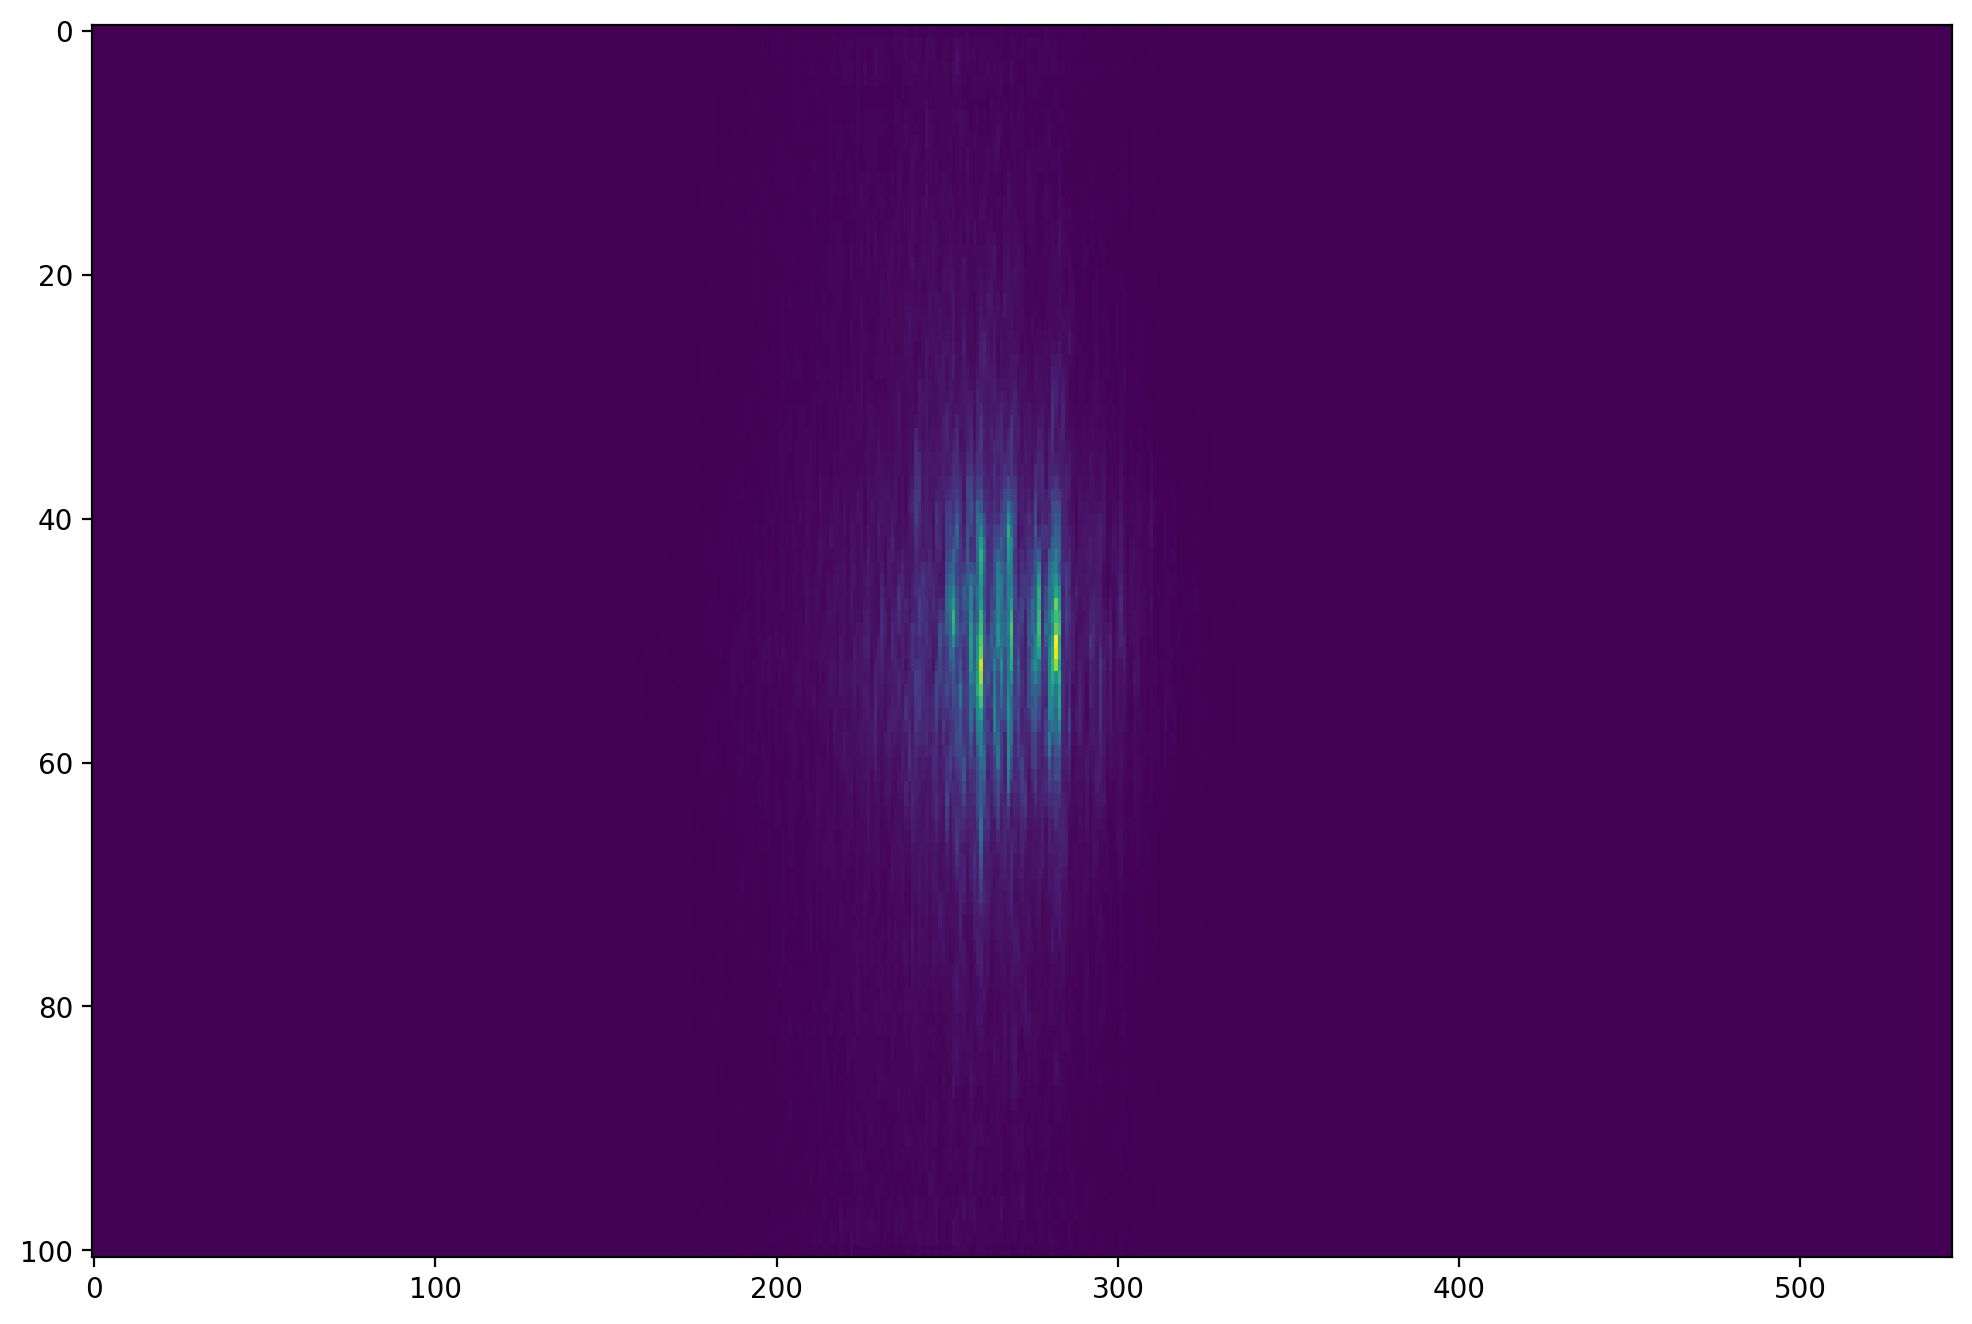

In [46]:
# Plot the center
plt.imshow(dat2[::,:], aspect='auto')

#plt.axis('off');plt.savefig('../../assets/field.png', bbox_inches='tight')

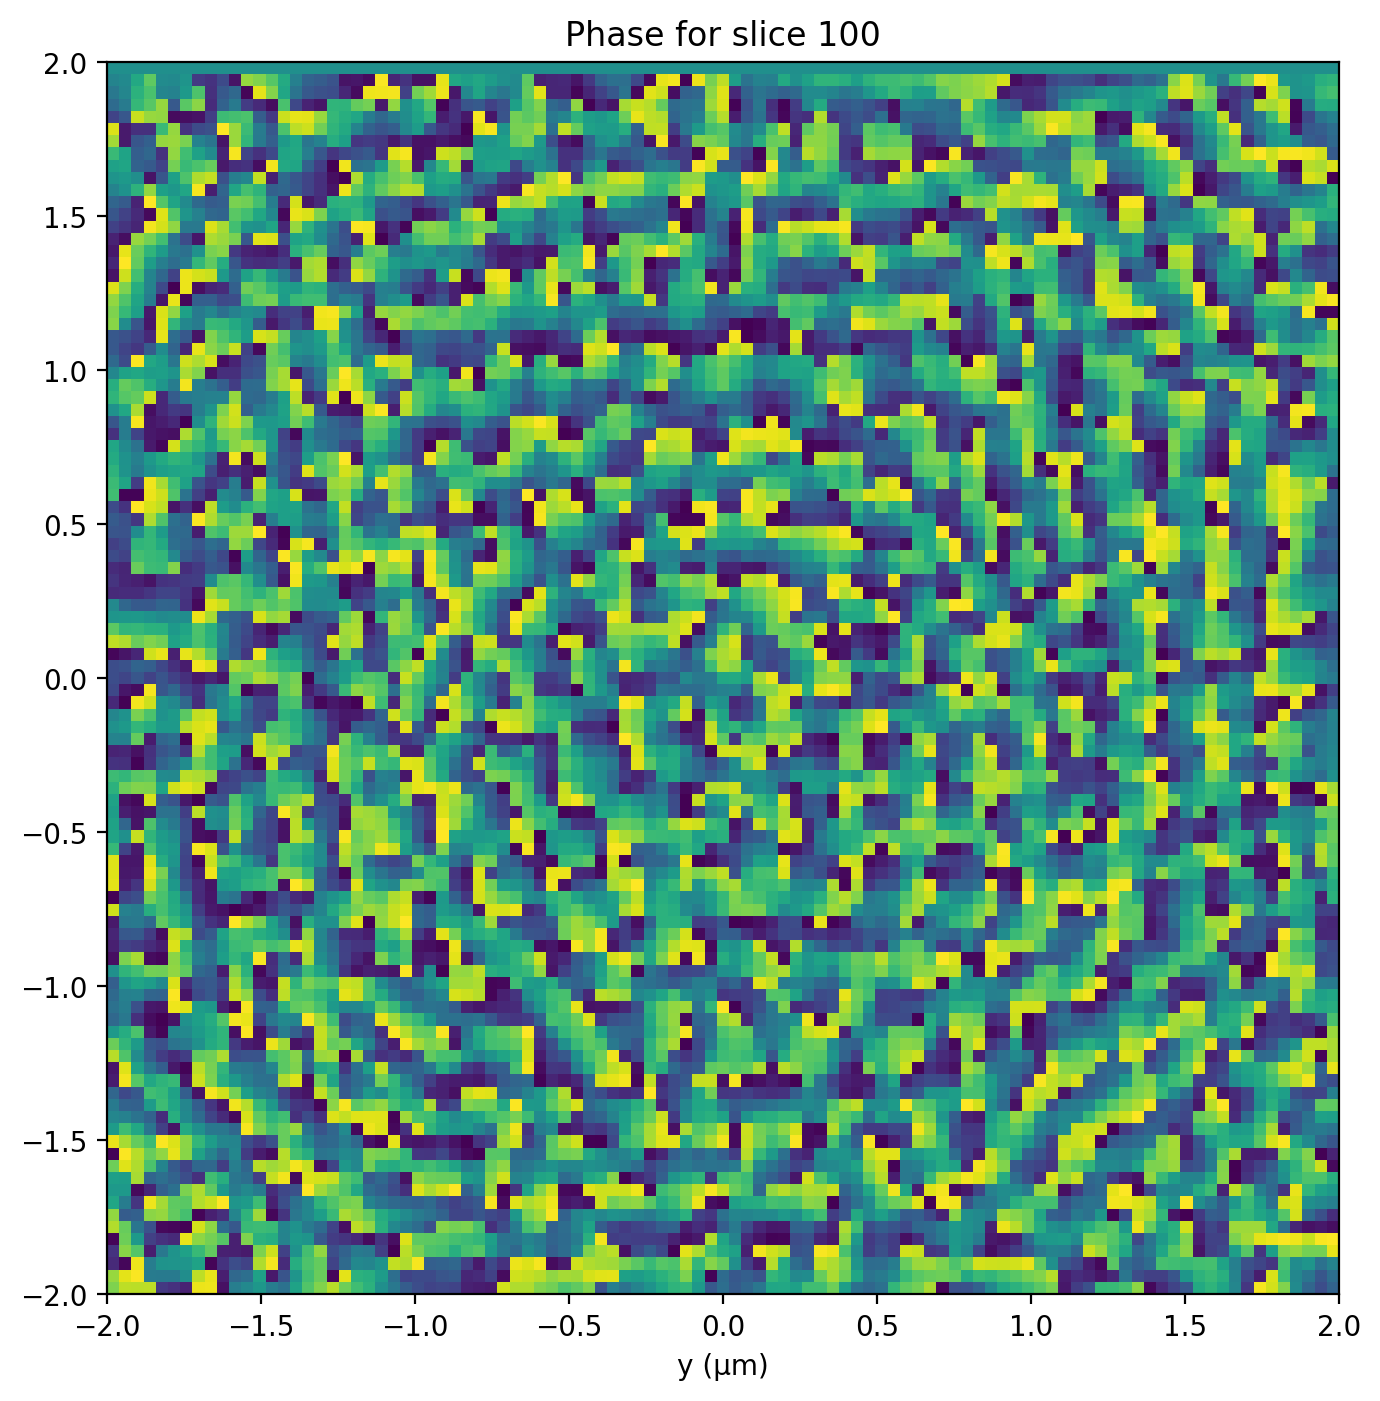

In [47]:
def plot_slice(i=0):
    
    dat = np.angle(DFL[:,:,i])
    
    dx = PARAM['gridsize']*1e6
    plt.xlabel('x (µm)')
    plt.xlabel('y (µm)')
    plt.title(f'Phase for slice {i}')
    plt.imshow(dat.T, origin='lower', extent=[-dx,dx,-dx,dx])
plot_slice(i=100)

# Interactive 

In [48]:
#from ipywidgets import interact

In [49]:
#interact(plot_slice, i=(0,len(DFL[0,0,:])-1, 1))

# Cleanup 

In [50]:
import os
os.remove("genesis4_wavefront.h5")